In [10]:
import pandas as pd
import numpy as np
import requests
import io 
import sharepy
import math
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
%matplotlib inline

#This is what connects to factset
auth = ('INSERT FACTSET FIRM ID', 'INSERT FACTSET PASSWORD')
endpoint = "https://datadirect.factset.com/services/FastFetch?"

#This function is what translates the output from FactSet into a pandas DF
def factset2pandasdf(response):
    data_df = pd.read_csv(io.StringIO(response.text), sep = '|')
    return data_df

#This function finds the benchmark constituents
def getconstituents(benchmark):
    df = requests.post(endpoint, auth=auth, data = {'factlet':'ExtractBenchmarkDetail', 
                                                      'ids': benchmark, 
                                                      'items':"P_SYMBOL(LOCAL), \
                                                              COMPANY_NAME()",
                                                      'dates': '', 
                                                      'format':'pipe',
                                                      'showTitle':'N',
                                                      'showHeader': 'N',
                                                      'showDataType':"N"})
    pandas_df = factset2pandasdf(df)
    return pandas_df['p_symbol'].to_list()


def returns(ticker, start, end):
    df = requests.post(endpoint, auth=auth, data = {'factlet':'ExtractFormulaHistory',
                                    'ids':ticker, 
                                    'items': f"FG_COMPANY_NAME, \
                                              p_price_returns(2, {start}, {end}, M)",                                           
                                    'dates': f"{start}:{end}:M",
                                    'format':'pipe',
                                    'showTitle':'N',
                                    'showHeader':'N',
                                    'showDataType':'N'})
    desired_df = factset2pandasdf(df)
    desired_df['Date'] = pd.to_datetime(desired_df['Date'])
    company_name = desired_df['fg_company_name'][0]
    #Renames the DataFrame Columns for readability
    desired_df = desired_df.rename(columns={
        "p_price_returns": f"{company_name}"
    })
    desired_df = desired_df[['Date', f'{company_name}']]
    return desired_df


In [2]:
# This is the query that grabs all of the tickers needed from the benchmark and the sectors
ticker_list = []
namelist = []
sectors = ['99900001','99900037','99900125','99900285','99900477','99900565','99900621','99900701','99900793','99900821','86099Y65']


communication_services_list = getconstituents('99900793')
consumer_discretionary_list = getconstituents('99900285')

ticker_list = communication_services_list
ticker_list.extend(consumer_discretionary_list)
ticker_list.extend(sectors)



In [4]:
# This is the query that pulls all of the return data
returns_df = pd.DataFrame()

for ticker in ticker_list:
    start = '20220101'
    end = '20231231'
    data_df = returns(ticker, start, end)
    if returns_df.empty:
        returns_df = data_df
    else:
        returns_df = returns_df.merge(data_df, right_on='Date', left_on='Date')
    

In [5]:
# This sets the index to the date, makes the analysis easier
returns_df = returns_df.set_index('Date')

In [6]:
# This filters to just Sector Returns
sector_returns = returns_df.iloc[:, 74:85]

In [7]:
# This filters to just stock Returns
stock_returns = returns_df.iloc[:, 0:73]

In [8]:
# This sets up the data for the PCA for stocks and sectors
X = returns_df
X_train_columns = returns_df.columns

In [9]:
# This runs the first PCA
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=returns_df.columns)

from sklearn.decomposition import PCA
pcamodel = PCA(n_components=15)
pca = pcamodel.fit_transform(X)

(24, 15)

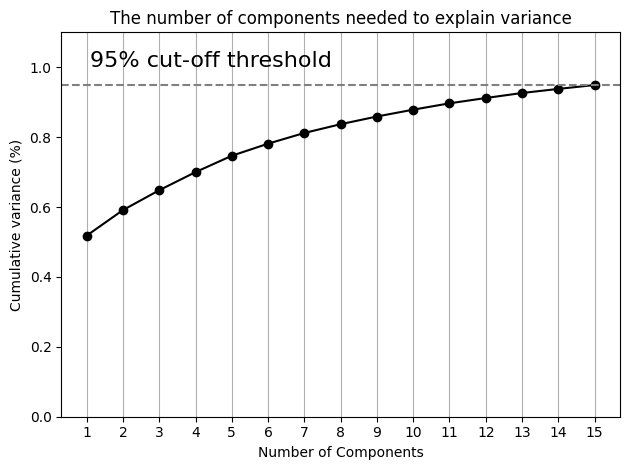

In [11]:
# Plotting for the first PCA
fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pcamodel.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 16, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

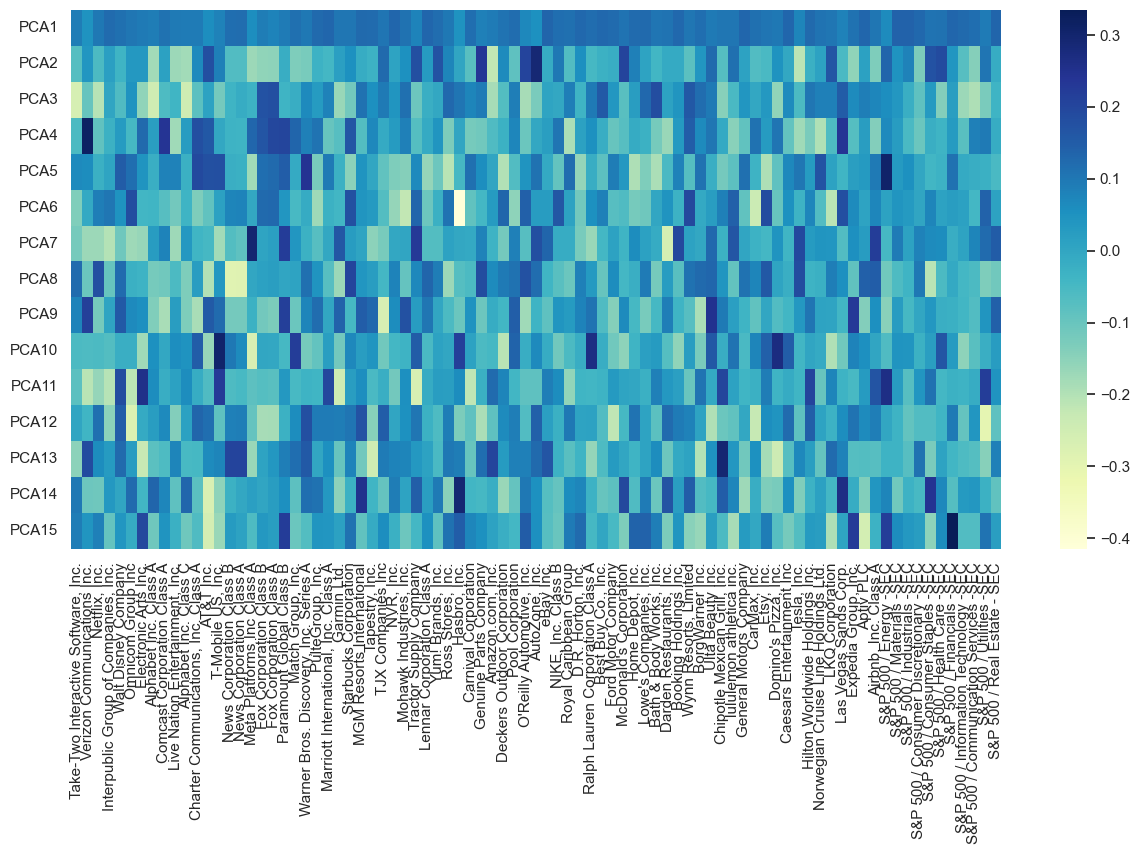

In [12]:
sns.set(rc={"figure.figsize":(15, 7)})
ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X) for X in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "vertical"})

In [13]:
# This runs for just the sectors
X = sector_returns
X_train_columns = sector_returns.columns

In [14]:
# Runs for the PCA of just sectors
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=sector_returns.columns)

pcamodel = PCA(n_components=6)
pca = pcamodel.fit_transform(X)

(24, 6)

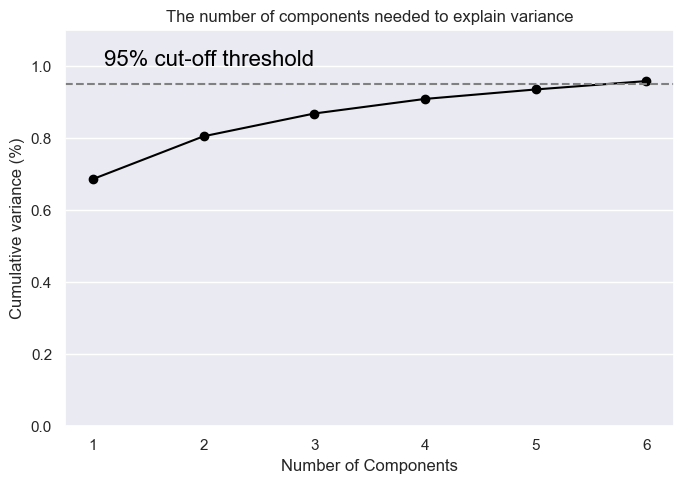

In [18]:
sns.set(rc={"figure.figsize":(7, 5)})
fig, ax = plt.subplots()
xi = np.arange(1, 7, step=1)
y = np.cumsum(pcamodel.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 7, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

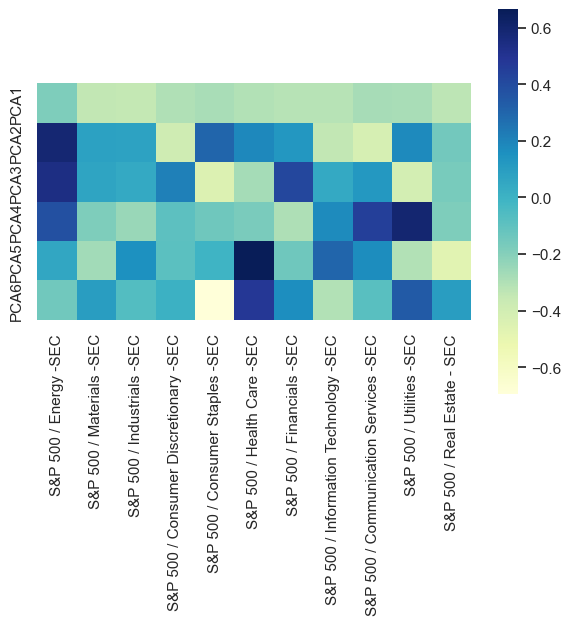

In [19]:
ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X) for X in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")

In [20]:
# This runs for just individual stocks
X = stock_returns
X_train_columns = stock_returns.columns

In [21]:
# Runs for the model
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=stock_returns.columns)

pcamodel = PCA(n_components=15)
pca = pcamodel.fit_transform(X)

(24, 15)

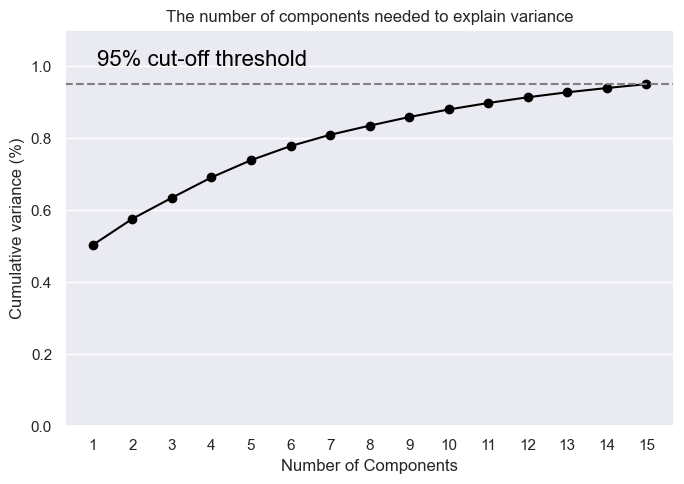

In [22]:
fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pcamodel.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 16, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

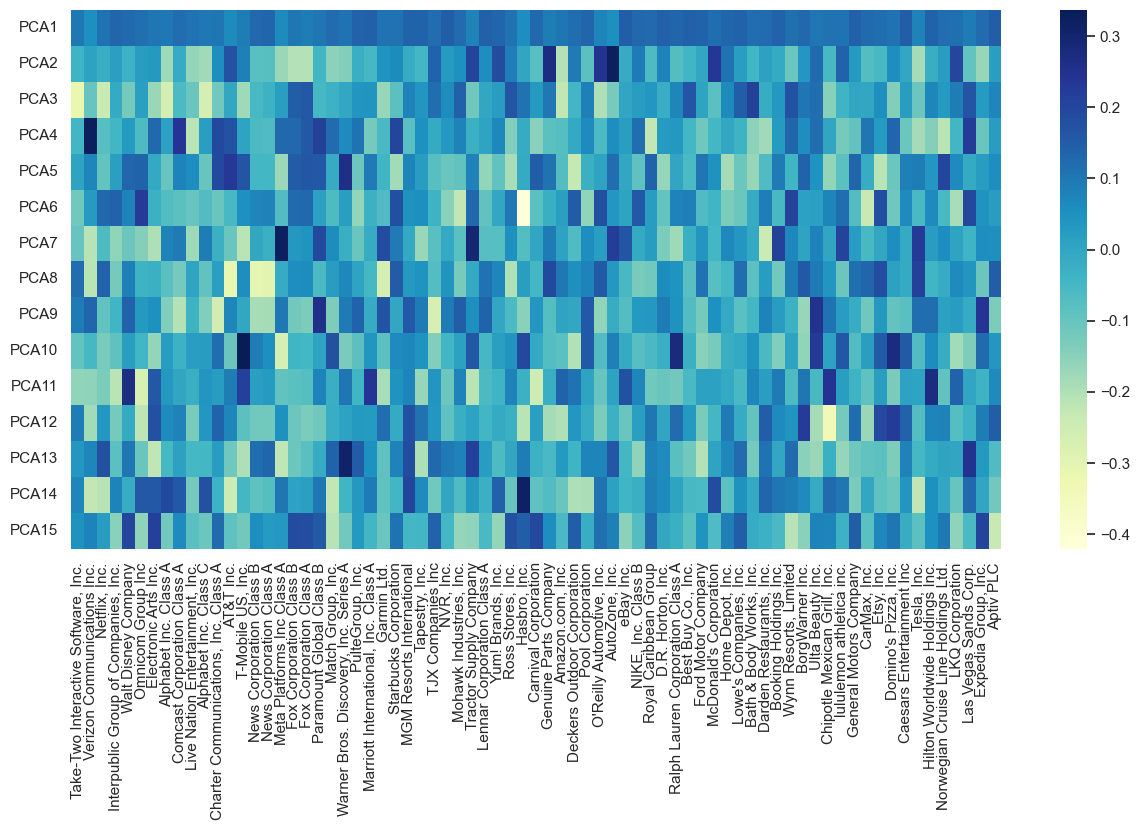

In [23]:
sns.set(rc={"figure.figsize":(15, 7)})
ax = sns.heatmap(pcamodel.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X) for X in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "vertical"})
